In [1]:
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPool1D, GlobalMaxPooling1D
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback, TensorBoard
from keras.datasets import mnist, imdb
from keras.utils import pad_sequences, plot_model

2023-03-23 10:53:16.957048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 10:53:17.004244: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Callbacks

## ModelCheckpoint & EarlyStopping

In [51]:
model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_val = X_test[:5000]
y_val = y_test[:5000]
X_test = X_test[5000:]
y_test = y_test[5000:]

In [38]:
callback_list = [
    EarlyStopping(monitor='acc', patience=1.), # Stop training when no imporvement after more than 1 epoch
    ModelCheckpoint( # save model weights after every epoch
        filepath='model_ckpt.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [39]:
model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    callbacks=callback_list,
    validation_data=(X_val,y_val)
)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 2.8301 - acc: 0.1581 - val_loss: 1.9390 - val_acc: 0.2604
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.7892 - acc: 0.2985 - val_loss: 1.6639 - val_acc: 0.3400
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.5811 - acc: 0.3573 - val_loss: 1.4796 - val_acc: 0.4074
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.4588 - acc: 0.4003 - val_loss: 1.4146 - val_acc: 0.4070
Epoch 5/10
1875/1875 [==============================] - 2s 992us/step - loss: 1.3258 - acc: 0.4662 - val_loss: 1.2845 - val_acc: 0.5032
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.2298 - acc: 0.5151 - val_loss: 1.1767 - val_acc: 0.5586
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.0830 - acc: 0.5921 - val_loss: 1.0526 - val_acc: 0.6204
Epoch 8/10
1875/1875 [==============================] - 2s 1

## ReduceLROPlateau
Reducing learning_rate when val_loss not improving. Manipulating lr value helps overcoming local minimas of loss functions

In [19]:
callback_list = [
    ReduceLROnPlateau(
        monitor='acc',
        factor=0.1, 
        patience=10 # when val_loss is not imporving for 10epochs
    )
]
model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    callbacks=callback_list,
    validation_data=(X_val,y_val),
    verbose=0
)

## Custom callbacks

In [54]:
# on_epoch_begin
# on_epoch_end
# on_batch_begin
# on_batch_end
# on_train_begin
# on_train_end

class ActivationLogger(Callback):
    
    def set_model(self, model):
        self.model = model
        layer_output = [layer.output for layer in model.layers]
        self.activations_model = Model(model.input, layer_output)
    
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation data')
            
        validation_sample = self.validation_data[0][0:1]
        activations = self.activations_model.predict(validation_sample)
        f = open('activations_at_epoch_' + str(epoch) + '.npz', 'w')
        np.savez(f, activations)
        f.close()


activation_logger = ActivationLogger()

#model.fit(X_train, y_train,
#          epochs=10,
#          batch_size=32,
#          validation_data=(X_val, y_val),
#          callbacks=[activation_logger])

# TensorBoard

In [2]:
# mkdir my_log_dir
# tensorboard --logdir=my_log_dir
# python3 -m tensorboard.main --logdir=my_log_dir

max_features = 2000
maxlen = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

model = Sequential([
    Embedding(max_features, 8, input_length=maxlen, name='embed'),
    Conv1D(32, 7, activation='relu'),
    MaxPool1D(5),
    Conv1D(32, 7, activation='relu'),    
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

callbacks = [
    TensorBoard(
        log_dir='my_log_dir',
        histogram_freq=1, # save histogram every epoch
        embeddings_freq=1
    )
]

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/20


2023-03-23 10:53:22.988859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 10:53:22.993003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 10:53:22.993144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 10:53:22.993448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable the

157/157 [==============================] - 16s 87ms/step - loss: 0.6532 - acc: 0.5965 - val_loss: 0.4316 - val_acc: 0.8098
Epoch 2/20
157/157 [==============================] - 11s 70ms/step - loss: 0.3593 - acc: 0.8450 - val_loss: 0.3577 - val_acc: 0.8472
Epoch 3/20
157/157 [==============================] - 10s 63ms/step - loss: 0.3035 - acc: 0.8727 - val_loss: 0.3699 - val_acc: 0.8442
Epoch 4/20
157/157 [==============================] - 9s 57ms/step - loss: 0.2813 - acc: 0.8842 - val_loss: 0.3474 - val_acc: 0.8522
Epoch 5/20
157/157 [==============================] - 7s 43ms/step - loss: 0.2643 - acc: 0.8921 - val_loss: 0.3516 - val_acc: 0.8538
Epoch 6/20
157/157 [==============================] - 7s 41ms/step - loss: 0.2497 - acc: 0.8998 - val_loss: 0.3556 - val_acc: 0.8486
Epoch 7/20
157/157 [==============================] - 5s 32ms/step - loss: 0.2346 - acc: 0.9078 - val_loss: 0.3611 - val_acc: 0.8512
Epoch 8/20
157/157 [==============================] - 4s 27ms/step - loss: 0.

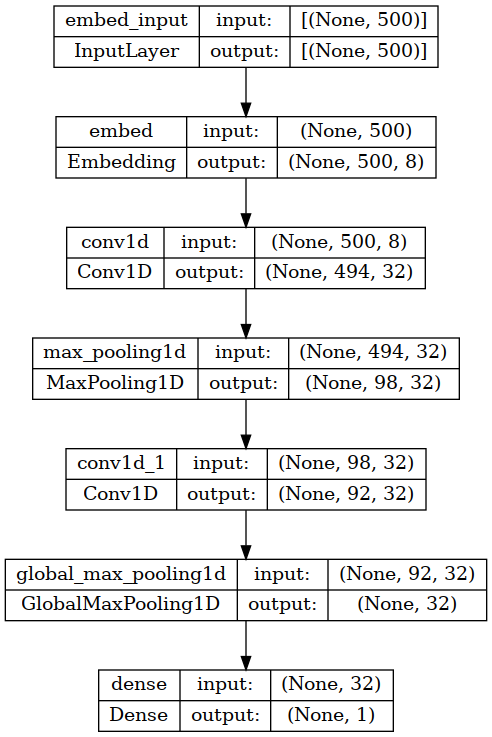

In [4]:
# install graphviz, pydot
plot_model(model, show_shapes=True, to_file='model.png')

# Batch Normalization & SeparableConv2D
- Batch normalization - normalize data after right after they come out from some layer. Great for very deep naural networks - possible performance and stability gain.
- SeparableConv2D - alternative for Conv2D - could be lighter, faster and more efficient. It performs sparse convolution of each channel independently and then Conv1x1 to mix channels. Using it makes sense when there is high correlation of sparse point of input data with relatively high independency of particular channels. (Xception)